<a href="https://colab.research.google.com/github/Sommppp/DataSet/blob/main/SegmentationBinaire_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Sommppp/DataSet

Cloning into 'DataSet'...
remote: Enumerating objects: 1043, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1043 (delta 79), reused 99 (delta 78), pack-reused 942
Receiving objects: 100% (1043/1043), 1.60 GiB | 29.61 MiB/s, done.
Resolving deltas: 100% (410/410), done.
Checking out files: 100% (1001/1001), done.


Récupération d'une base de données sur Github :


**Lecture de la base de données** : nous allons créer des tenseurs x et y, respectivement les images de base (données) et les masques associés (labels). Il faut définir une taille pour nos données : en général, on se débrouille pour avoir des images carrées toutes de la même dimension. Plus les images sont grandes plus les calculs seront longs et coûteux. Pour démarrer, je vous suggère des images de taille $64 \times 64$.

In [21]:
import os
import PIL
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split


# Pourra être changé plus tard
IMAGE_SIZE = 128

path = './DataSet/'
list_images = os.listdir(path + 'image/')
nb_img = len(list_images)

# Initialise les structures de données
x = np.zeros((nb_img, IMAGE_SIZE, IMAGE_SIZE, 3))
y = np.zeros((nb_img, IMAGE_SIZE, IMAGE_SIZE, 1))
  
i = 0

for img_name in list_images:
  # Lecture de l'image
  img = Image.open(path + 'image/' + img_name)
  # Mise à l'échelle de l'image
  img = img.resize((IMAGE_SIZE,IMAGE_SIZE), Image.ANTIALIAS)
  # Remplissage de la variable x
  x[i] = np.asarray(img)

  # Lecture d'un masque
  m = Image.open(path + 'mask/' + img_name.split('.')[0] + '_mk.png')
  # Mise à l'échelle du masque
  m = m.resize((IMAGE_SIZE,IMAGE_SIZE), Image.ANTIALIAS)
  # Remplissage de la variable x
  y[i] = np.expand_dims(np.asarray(m), axis=-1)
  i = i + 1


# Pour que l'apprentissage se passe bien, on normalise les valeurs de pixel entre 0 et 1
x = x/255
# Idem pour les masques
y = y/255

# Création d'un ensemble d'apprentissage et d'un ensemble de test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)

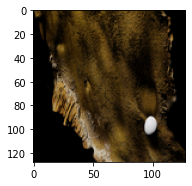

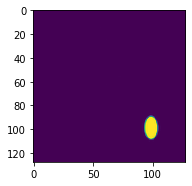

In [33]:
import matplotlib.pyplot as plt
import random

idx_img = random.randint(0, x_train.shape[0])
# Affichage d'une image aléatoire et de son masque associé
plt.subplot(1,2,1)
plt.imshow(x_train[idx_img])
plt.show()

plt.subplot(1,2,2)
plt.imshow(np.squeeze(y_train[idx_img]))
plt.show()

Pour vous aider pour la suite, voici ci-dessous une implémentation du réseau UNet, vu en cours sur la segmentation.

![Texte alternatif…](https://raw.githubusercontent.com/zhixuhao/unet/master/img/u-net-architecture.png)





In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import *

def create_unet(image_size=572):
  input_layer=Input((image_size, image_size, 3))

  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2,  2))(conv3)
  
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  
  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)


  model = Model(input_layer, conv10)

  return model

In [35]:
from tensorflow.keras import optimizers

model = create_unet(image_size=IMAGE_SIZE)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=10)

Epoch 1/15
45/45 [==============================] - 14s 196ms/step - loss: 0.1668 - accuracy: 0.9328 - val_loss: 0.1041 - val_accuracy: 0.9344
Epoch 2/15
45/45 [==============================] - 9s 191ms/step - loss: 0.0494 - accuracy: 0.9415 - val_loss: 0.0278 - val_accuracy: 0.9408
Epoch 3/15
45/45 [==============================] - 9s 191ms/step - loss: 0.0171 - accuracy: 0.9462 - val_loss: 0.0174 - val_accuracy: 0.9425
Epoch 4/15
45/45 [==============================] - 9s 192ms/step - loss: 0.0129 - accuracy: 0.9469 - val_loss: 0.0161 - val_accuracy: 0.9429
Epoch 5/15
45/45 [==============================] - 9s 193ms/step - loss: 0.0119 - accuracy: 0.9470 - val_loss: 0.0151 - val_accuracy: 0.9430
Epoch 6/15
45/45 [==============================] - 9s 194ms/step - loss: 0.0120 - accuracy: 0.9470 - val_loss: 0.0147 - val_accuracy: 0.9431
Epoch 7/15
45/45 [==============================] - 9s 195ms/step - loss: 0.0103 - accuracy: 0.9473 - val_loss: 0.0140 - val_accuracy: 0.9431
Epoch

On va maintenant effectuer une prédiction sur les données de test et les afficher, pour voir ce que le réseau a appris :

In [36]:
y_pred = model.predict(x_test)

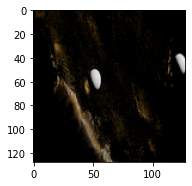

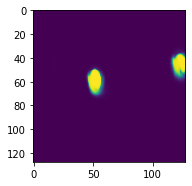

In [48]:
idx_img = random.randint(0, x_test.shape[0]-1)
# Affichage d'une image aléatoire et de son masque associé
plt.subplot(1,2,1)
plt.imshow(x_test[idx_img])
plt.show()

plt.subplot(1,2,2)
plt.imshow(np.squeeze(y_pred[idx_img]))
plt.show()

Les préditions sont plutôt bonnes ! **Notez bien qu'elles sont effectuées sur des données non utilisées pendant l'apprentissage**